In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'sanity_four_body_bar_10kpc'
seed = 0
cutoff = 100

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':['bar'],
                'stationary_potential_kwargs_list':[{'M':1e10, 'a':5000, 'b':1500, 'c':1000, 'omega_p':0.0}],
                # 'stationary_potential_list':['point_source'],
                # 'stationary_potential_kwargs_list':[{'M':1e10}],
                # 'stationary_potential_list':[],
                # 'stationary_potential_kwargs_list':[{}],
                # 'dynamic_potential_list':['point_source','point_source'],
                # 'dynamic_potential_list':['tracer','tracer'],
                # 'dynamic_potential_kwargs_list':[{'M':1e10}, {'M':1e10}],
                'dynamic_potential_list':['point_source', 'point_source', 'point_source', 'point_source'],
                'dynamic_potential_kwargs_list':[{'M':1e10}, {'M':1e10}, {'M':1e10}, {'M':1e10}],
                'seed':seed,
                'box_scaling':1000,
                'orbit_duration':500,
                'orbit_timesteps':500,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params):
    env.reset()
    print(init_params)
    init_params = {key:value/env.high for key,value in init_params.items()}
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    # reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    # reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6][:cutoff], orbit.y[agent*6+1][:cutoff], orbit.y[agent*6+2][:cutoff], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6][:cutoff], orbit_delta.y[agent*6+1][:cutoff], orbit_delta.y[agent*6+2][:cutoff], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0][:cutoff], orbit.y[agent*6+1][:cutoff], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0][:cutoff], orbit_delta.y[agent*6+1][:cutoff], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    # ax3 = fig.add_subplot(133)
    # ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    # ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0.5, 1.0, 'Initial positions studied, projected on the XY plane')

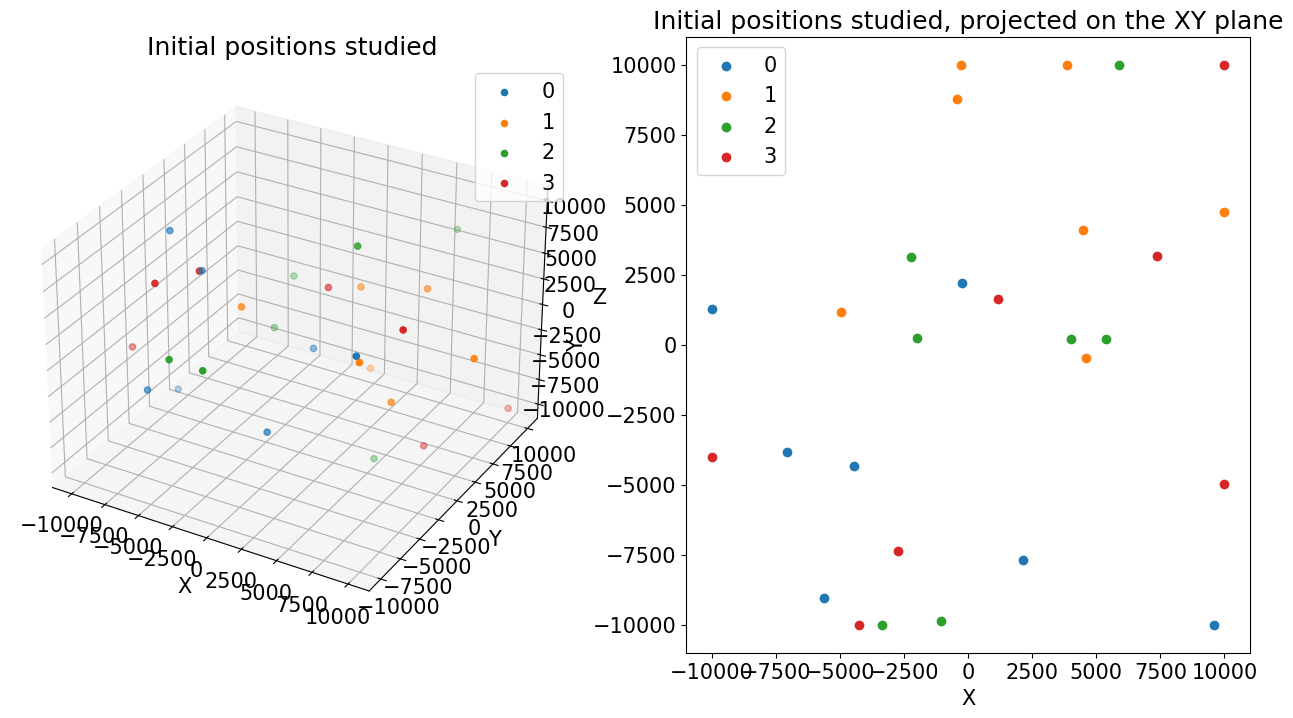

In [5]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('Initial positions studied')

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.set_title('Initial positions studied, projected on the XY plane')

In [6]:
def result_to_init(i):
    return {agent:(result_init_params[agent][:,i]) for agent in range(env.num_agents)}

{0: array([-10000.        ,   1279.29162598, -10000.        ,  -1000.        ,
          680.62194824,    951.1541748 ]), 1: array([  -283.89819336,  10000.        , -10000.        ,     28.19384956,
        -1000.        ,   1000.        ]), 2: array([ 4.00336621e+03,  2.21178757e+02,  1.00000000e+04, -2.18280106e+01,
        7.37318563e+00, -2.66857224e+01]), 3: array([  7379.76855469,   3167.39746094, -10000.        ,    178.58323669,
         -156.55549622,   -322.87075806])}
{0: np.float64(6.9049460818548376e-18), 1: np.float64(8.42457794305488e-18), 2: np.float64(1.8246542361960481e-16), 3: np.float64(6.958988432237264e-18)}


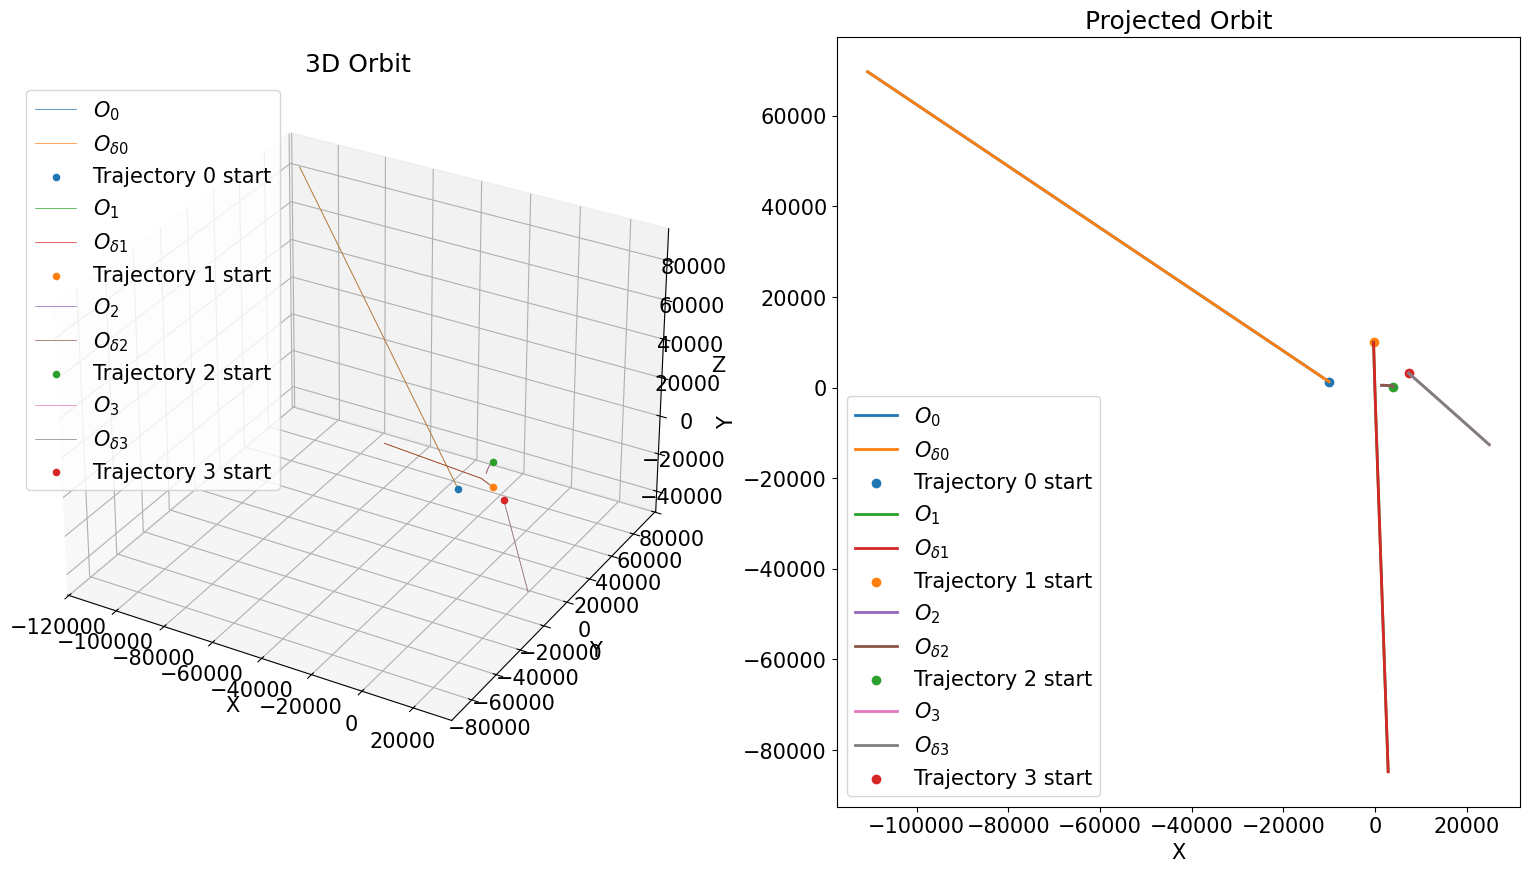

In [7]:
plot_from_init(result_to_init(0))

In [8]:
# init_params = {0:np.array([1000,0,0,0,1,0]), 1:np.array([-1000,0,0,0,-1,0])}
# plot_from_init(init_params)

{0: array([-4454.33837891, -4337.47314453,  7503.87207031, -1000.        ,
        1000.        ,  -674.64575195]), 1: array([10000.        ,  4725.93896484, -1393.34619141,   -22.67038345,
         -15.40644073,    81.75482941]), 2: array([-1.98082996e+03,  2.41531876e+02,  1.52915716e+00, -9.64977051e+02,
        1.00000000e+03, -1.00000000e+03]), 3: array([ -4252.44042969, -10000.        ,  10000.        ,    113.18258667,
         -400.89587402,   -897.08605957])}
{0: np.float64(6.988342275096938e-18), 1: np.float64(2.1839761277883947e-16), 2: np.float64(6.980918290927619e-18), 3: np.float64(6.959843722234519e-18)}


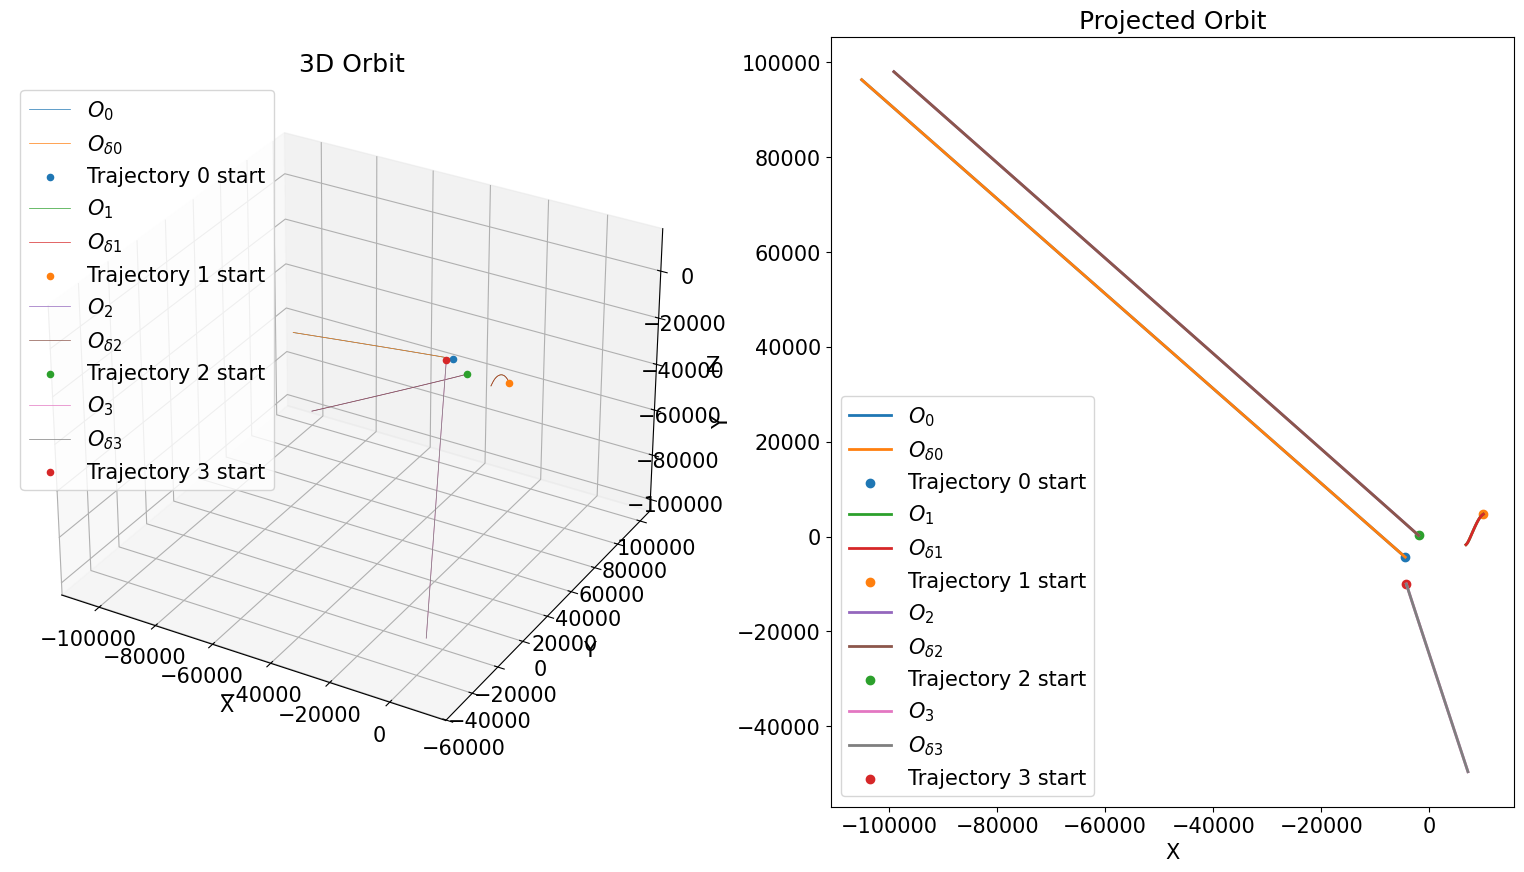

In [9]:
plot_from_init(result_to_init(1))

{0: array([-7071.22460938, -3825.43334961, 10000.        ,   814.62512207,
         907.04418945,   379.77105713]), 1: array([ -419.49563599,  8791.52929688,  -961.11138916,   -75.96278381,
       -1000.        ,   190.37997437]), 2: array([  5360.36865234,    214.60276794, -10000.        ,    -91.07286072,
        -1000.        ,     41.28017807]), 3: array([ 10000.        ,  10000.        , -10000.        ,    507.86651611,
         1000.        ,  -1000.        ])}
{0: np.float64(1.9242752301902966e-17), 1: np.float64(6.278037319406411e-17), 2: np.float64(6.175187563094303e-17), 3: np.float64(1.9093631161293422e-17)}


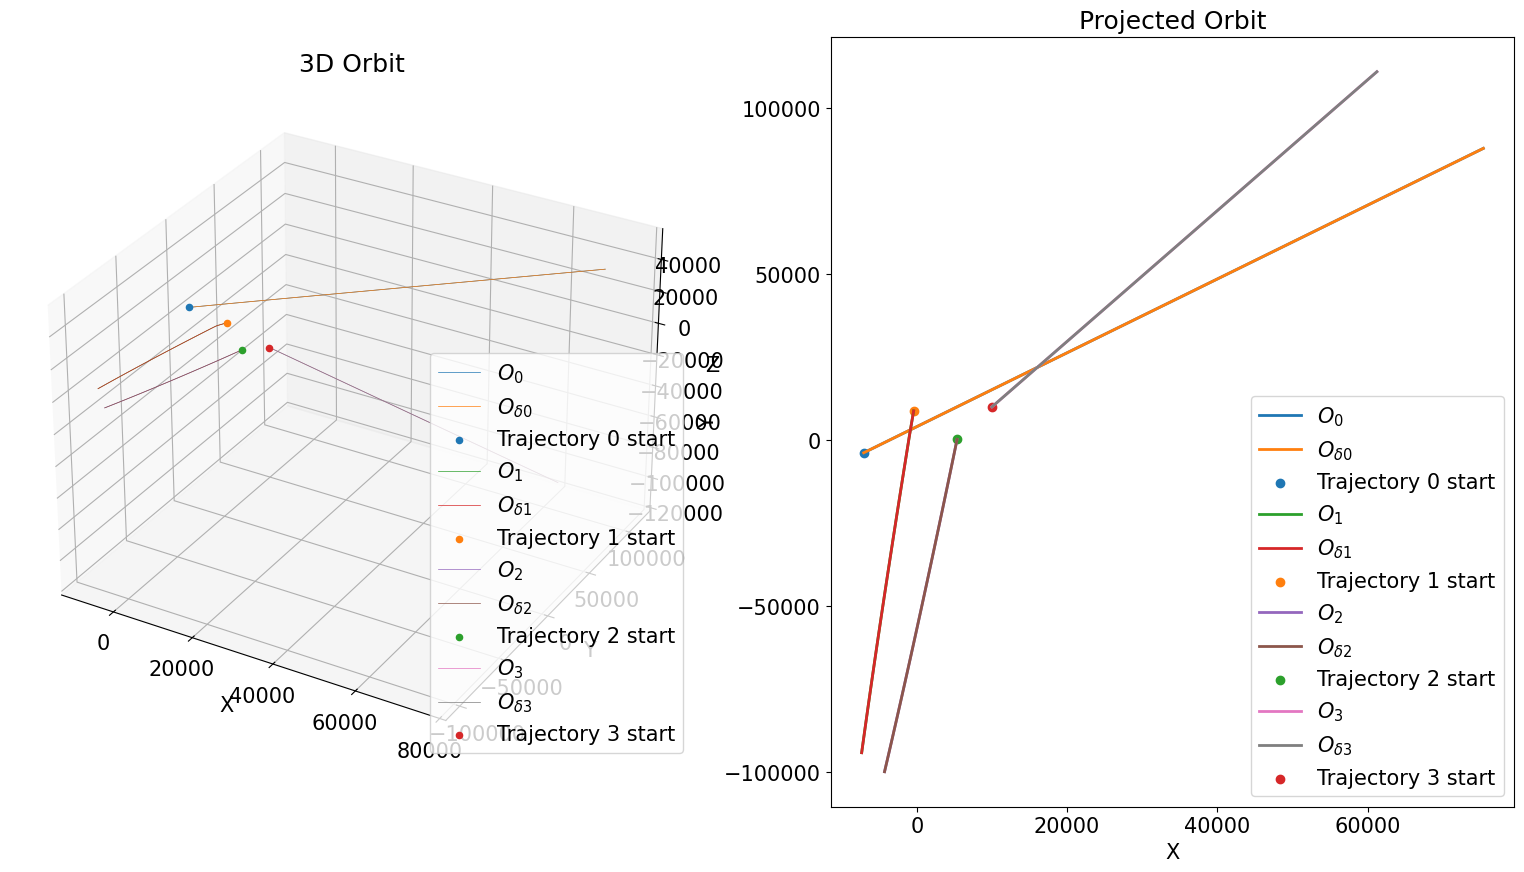

In [10]:
plot_from_init(result_to_init(2))

{0: array([-5639.57324219, -9032.625     , -1190.64257812,   482.29806519,
         551.25939941,  -752.64343262]), 1: array([4594.23291016, -459.4458313 , -368.52471924,  -21.62750816,
         63.57958984,  204.64205933]), 2: array([-1053.67236328, -9880.00292969,  3039.11376953,  1000.        ,
         696.71282959,   806.07409668]), 3: array([-2745.0949707 , -7353.89160156, 10000.        ,   436.92745972,
        -780.10113525,  1000.        ])}
{0: np.float64(9.204748627312029e-18), 1: np.float64(2.0246500023667666e-16), 2: np.float64(7.796196200237707e-18), 3: np.float64(6.708142936617031e-18)}


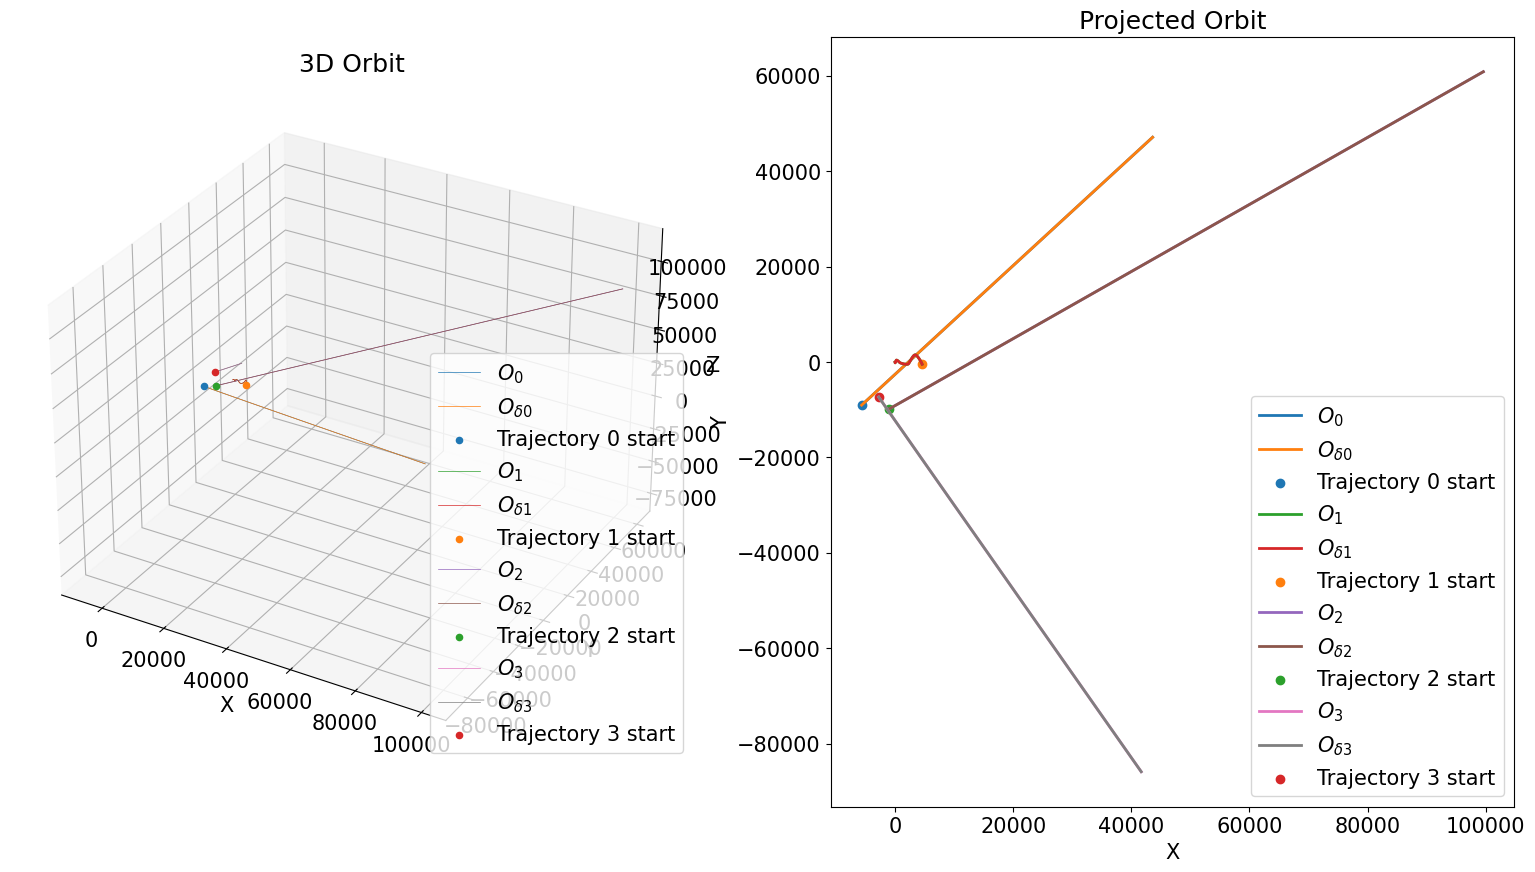

In [11]:
plot_from_init(result_to_init(3))

{0: array([  9603.54199219, -10000.        ,   8650.02636719,    948.60864258,
          764.59680176,   1000.        ]), 1: array([-4963.82177734,  1167.70202637,   300.39584351,    29.29087639,
        -347.13806152,   919.5524292 ]), 2: array([ 5899.25292969, 10000.        ,  6225.65820312,   334.92172241,
         139.13934326,  -793.68774414]), 3: array([10000.        , -4960.14550781,  7810.35839844,   931.23052979,
         772.43682861,  1000.        ])}
{0: np.float64(4.411195538950433e-17), 1: np.float64(2.860115714920497e-17), 2: np.float64(2.4203589498288345e-17), 3: np.float64(4.5096766455768055e-17)}


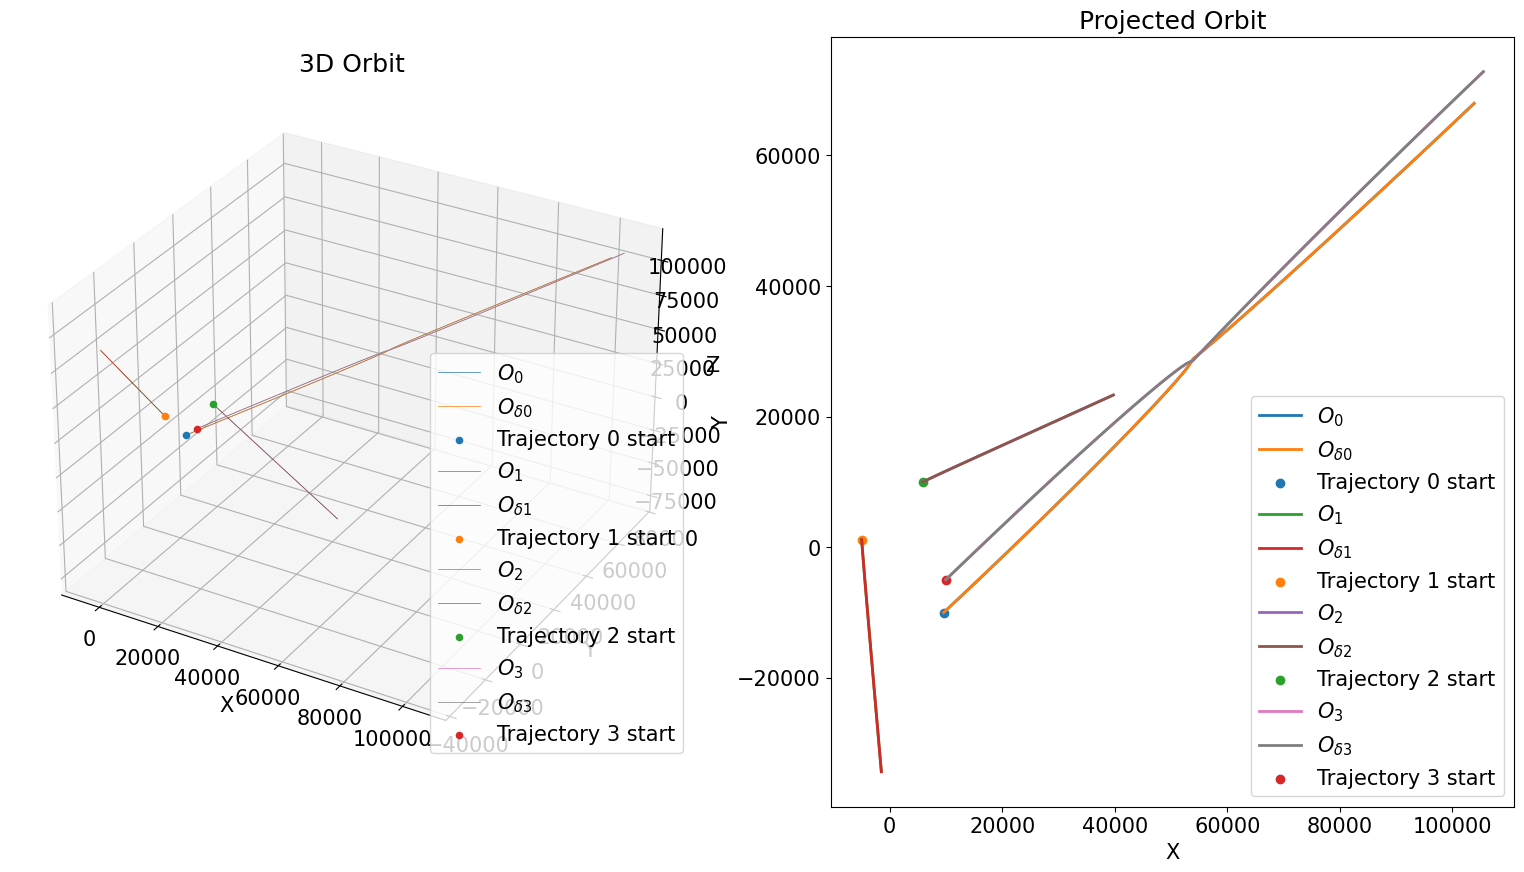

In [12]:
plot_from_init(result_to_init(4))

{0: array([ 2141.4128418 , -7672.8515625 , -3042.51660156,  1000.        ,
        -817.97045898, -1000.        ]), 1: array([ 4463.61621094,  4102.28271484, -7488.3359375 ,  1000.        ,
        -792.11859131, -1000.        ]), 2: array([-2224.80004883,  3142.82763672,  3066.56420898,  1000.        ,
         209.4087677 , -1000.        ]), 3: array([-10000.        ,  -4010.92358398,  -2136.47338867,   1000.        ,
        -1000.        ,   -551.58416748])}
{0: np.float64(5.65079126492572e-17), 1: np.float64(5.770372399694306e-17), 2: np.float64(1.785559379374252e-17), 3: np.float64(2.6233284091664493e-17)}


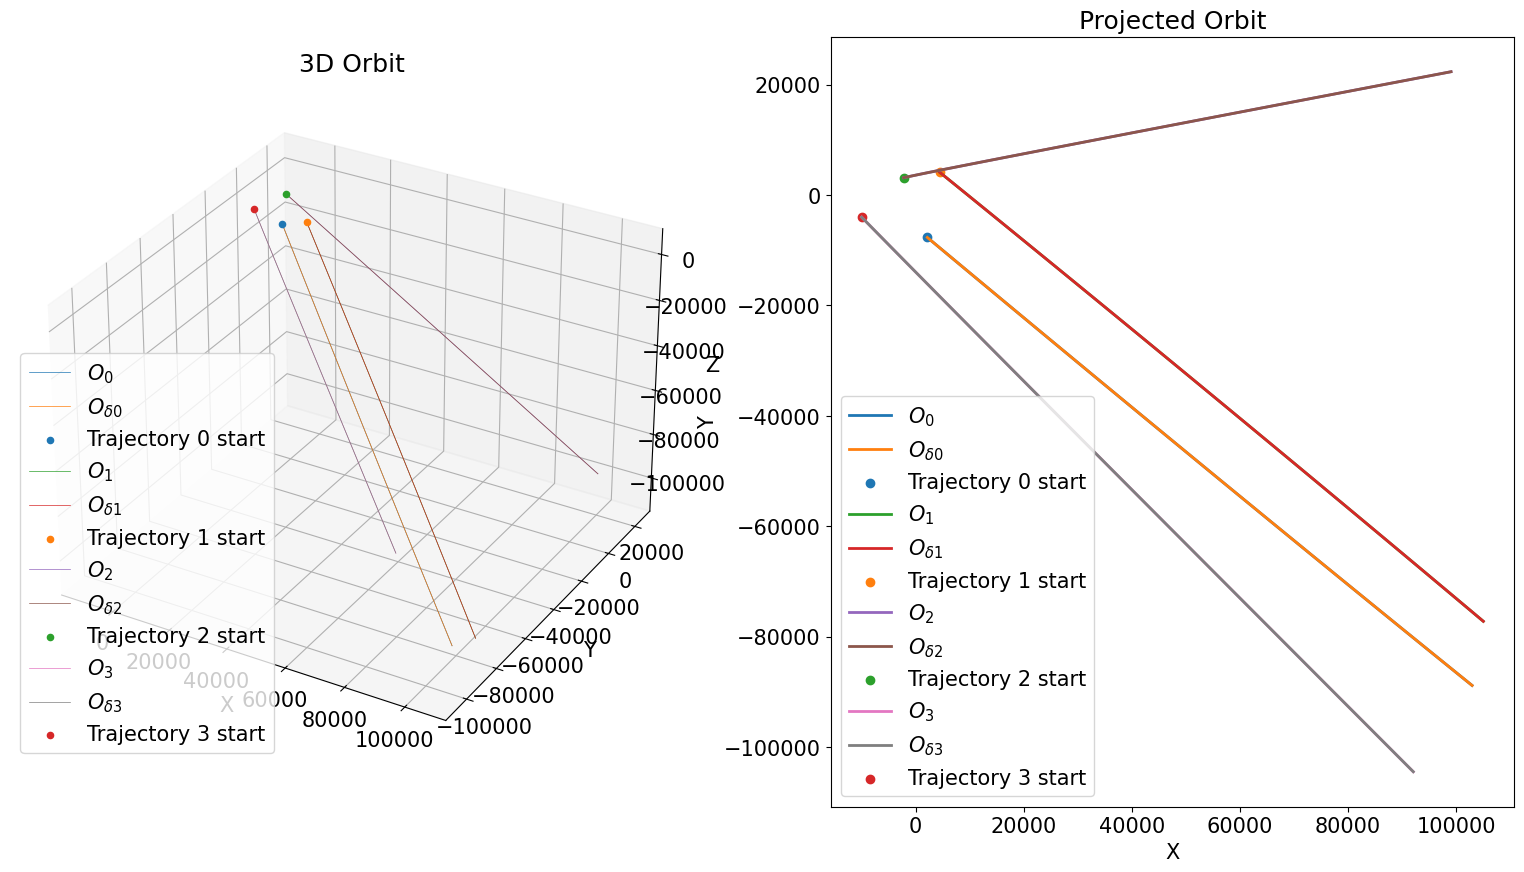

In [13]:
plot_from_init(result_to_init(5))